In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from torchvision import utils
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
torch.manual_seed(seed=seed)
torch.set_float32_matmul_precision("high")

if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed=seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
train_dataset = datasets.FashionMNIST(root='/home/pervinco/Datasets/FashionMNIST', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='/home/pervinco/Datasets/FashionMNIST', train=False, transform=transforms.ToTensor(), download=True)

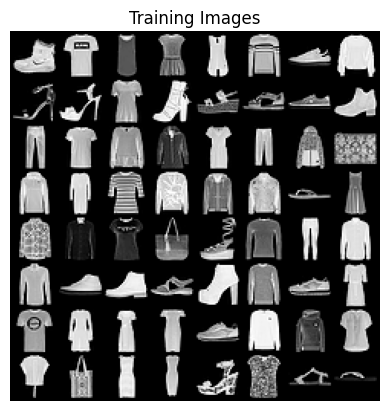

In [4]:
plt.axis('off')
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(torch.cat([train_dataset[i][0].unsqueeze(0) for i in range(64)], dim=0), normalize=True), (1,2,0)))

## Leaky ReLU와 ReLU는 어떤 차이가 있는지 생각해보기
### ReLU (Rectified Linear Unit):

$$ f(x)=max(0,x) $$ 

ReLU는 가장 널리 사용되는 활성화 함수 중 하나로, 입력이 양수인 경우에는 그대로 통과시키고, 음수인 경우에는 0으로 만들어 버립니다.
- 장점: 계산이 간단하고, 비선형성을 제공하며, 기울기 소실 문제(vanishing gradient problem)를 완화합니다.
- 단점: 음수 입력에 대해 출력이 항상 0이므로, 학습 과정에서 특정 뉴런이 죽는 현상(dying ReLU problem)이 발생할 수 있습니다. 즉, 음수 입력을 자주 받는 뉴런들은 더 이상 업데이트되지 않을 수 있습니다.


### Leaky ReLU

Leaky ReLU는 ReLU의 변형으로, 음수 입력에 대해 작은 기울기를 유지하는 방식입니다.

$$ f(x)=max(0.01x,x)$$  

- 여기서 0.01은 negative_slope 입니다.
- 장점: 음수 입력에서도 기울기를 유지하기 때문에, 뉴런이 완전히 죽는 것을 방지할 수 있습니다. 이는 모델이 더 깊은 네트워크에서 더 잘 학습할 수 있게 합니다.
- 단점: 음수 부분의 기울기가 작기 때문에, 여전히 음수 영역에서의 업데이트는 제한적일 수 있습니다.

결론적으로, Leaky ReLU는 ReLU의 단점을 일부 보완하여 더 안정적인 학습을 가능하게 하지만, 이로 인해 계산 비용이 크게 증가하지 않습니다. 따라서 Leaky ReLU는 음수 영역에서도 기울기를 유지해야 하는 경우에 유리합니다.


## Sigmoid가 아닌 Hyperbolic Tangent를 쓰면 어떻게 될지 생각해보기
### Sigmoid 함수

- Sigmoid 함수는 출력값을 (0, 1) 범위로 압축합니다.
- 주로 확률을 모델링하거나, 출력이 [0, 1] 사이의 값을 가지도록 해야 하는 경우에 사용됩니다.
- 단점: Sigmoid는 양쪽 끝에서 기울기가 매우 작아지는 문제(기울기 소실 문제)가 발생할 수 있습니다. 이로 인해 깊은 신경망에서 학습이 느려지거나, 초기화가 잘못되면 학습이 제대로 이루어지지 않을 수 있습니다.

## Hyperbolic Tangent (tanh)

tanh 함수는 출력값을 (-1, 1) 범위로 압축합니다.
 
- tanh는 입력이 0에 가까울수록 출력도 0에 가깝고, 큰 음수나 큰 양수 입력에 대해서는 -1 또는 1에 가까운 값을 가집니다.
- 장점: tanh는 출력이 중심에서 0을 가지기 때문에, 데이터의 평균이 0에 가깝도록 정규화된 경우 더 잘 작동할 수 있습니다. 이로 인해 모델의 수렴 속도가 빨라질 수 있습니다.
- 단점: Sigmoid와 마찬가지로 tanh도 양쪽 끝에서 기울기 소실 문제가 발생할 수 있습니다.

결론적으로, tanh를 사용하면 출력 범위가 (-1, 1)로 확장되어, 데이터가 중앙에 집중되어 있는 경우 더 나은 성능을 보일 수 있습니다. 하지만, 기울기 소실 문제는 여전히 존재할 수 있으므로, 이를 해결하기 위해서는 추가적인 기술(예: batch normalization 또는 고급 활성화 함수)을 사용할 필요가 있을 수 있습니다.

따라서, 출력이 0을 중심으로 대칭적인 값을 가지는 경우가 유리한 상황이라면 tanh를 사용하는 것이 더 적합할 수 있으며, 반대로 출력을 0과 1 사이로 제한해야 하는 경우라면 sigmoid를 사용하는 것이 좋습니다.

In [5]:
## Encoder, Decoder 구조는 일반 AutoEncoder과 동일

class Encoder(nn.Module):
    def __init__(self, latent_dim: int=20):
        super().__init__()

        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_mean = nn.Linear(128, latent_dim)

    def forward(self, x: torch.Tensor):
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        z = F.leaky_relu(self.fc_mean(x))
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dim: int=20):
        super().__init__()

        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 784)

    def forward(self, z: torch.Tensor):
        z = F.leaky_relu(self.fc1(z), negative_slope=0.2)
        z = F.leaky_relu(self.fc2(z), negative_slope=0.2)
        x_hat = F.sigmoid(self.fc3(z))
        x_hat = x_hat.view(x_hat.size(0), 1, 28, 28)

        return x_hat

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, encoder=Encoder, decoder=Decoder, latent_dim: int=20):
        super().__init__()
        self.encoder = encoder(latent_dim=latent_dim)
        self.decoder = decoder(latent_dim=latent_dim)

        self.latent_dim = latent_dim

    def forward(self, x: torch.Tensor):
        z = self.encode(x)
        x_hat = self.decode(z)
        return z, x_hat

    def encode(self, x: torch.Tensor):
        return self.encoder(x)

    def decode(self, z: torch.Tensor):
        return self.decoder(z)

인코더 클래스를 상속받아 변분 오토 인코더를 변분 인코더 클래스를 구현합니다. 오토 인코더의 인코더 클래스와의 차이점은 한 가지입니다. 인코더의 출력이 결정론적 (Deterministic) 값이 아닌 확률적 (Probabilistic) 평균과 분산입니다.

In [7]:
## Encoder 클래스를 상속 받았기 때문에 부모 클래스에 정의된 것들을 그대로 사용할 수 있다.
class VariationalEncoder(Encoder):
    def __init__(self, latent_dim: int=20):
        super().__init__(latent_dim=latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1) ## flatten
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)

        # 오토 인코더와의 주요 차이점
        mean = self.fc_mean(x) ## 일반 오토인코더는 여기서 반환하는 값이 잠재 벡터
        log_var = self.fc_log_var(x) ## mean을 입력하는게 아니라 x를 입력해서 log_variance를 얻는다.

        return mean, log_var ## mean과 log_variance를 반환

오토 인코더 클래스를 상속받아 변분 오토 인코더 클래스를 정의합니다. 오토 인코더 클래스와의 차이점은 크게 두 가지입니다.

1. 재매개변수화 구현: 재매개변수화 트릭을 이용하여 변분 오토 인코더의 기울기 계산을 가능하게 합니다.
2. forward 메소드에 재매개변수화 과정을 추가하여 샘플링 과정을 진행

In [8]:
class VariationalAutoencoder(Autoencoder):
    def __init__(self, encoder=VariationalEncoder, decoder=Decoder, latent_dim: int=16):
        super().__init__(latent_dim=latent_dim)
        self.encoder = encoder(latent_dim)

    def reparameterize(self, mean: torch.Tensor, log_var: torch.Tensor):
        ## 샘플링 시에도 기울기를 전달할 수 있도록 재매개변수화 합니다.
        std = torch.exp(0.5 * log_var) ## log_variance를 standard deviation으로 바꾼다.
        
        # randn_like 메소드는 입력된 인자와 같은 차원의 값들을 표준 정규 분포에서 샘플링하여 반환합니다.
        epsilon = torch.randn_like(std)

        return mean + (epsilon * std)

    def forward(self, x: torch.Tensor):
        # 인코더를 통해 얻어지는 값이 오토 인코더와 다릅니다.
        mean, log_var = self.encode(x)

        # 재매개변수화를 진행합니다.
        z = self.reparameterize(mean, log_var)
        
        # 오토 인코더와 같습니다.
        x_hat = self.decode(z)

        return x_hat, mean, log_var

변분 오토 인코더는 오토 인코더 구조를 가지는 **생성 모델**이며, 잠재 변수로부터 디코딩 과정을 거쳐 데이터를 **생성**합니다. 즉, 변분 오토 인코더는 오토 인코더에서 데이터를 **복원**하는 것과는 다른 목적을 가지고 있습니다. 이 과정을 변분 오토 인코더에서는 **샘플링**을 통해 진행합니다. 오토 인코더에서 하나의 값으로 정해졌던 인코더의 출력이, 평균과 분산 두 가지로 나뉘며 값이 아닌 분포를 출력하게 됩니다. 평균과 분산을 이용하여 정규 분포를 추정한 후, 해당 분포에서 샘플링을 진행하게 됩니다.

변분 오토 인코더의 디코더는 오토 인코더의 디코더와 같으며, 데이터를 **생성**하는 역할을 담당하고 있습니다. 이미지 데이터를 생성한다고 가정했을 때, 디코더의 출력 값 범위에 대해 한번 생각해볼 필요가 있습니다. 디코더의 출력은, 인코더의 입력 데이터의 분포를 근사하는 것을 목적으로 하기 때문에 인코더의 입력 값의 분포와 동일한 것이 좋습니다. 인공 신경망을 학습할 때, 보편적으로 이미지 데이터는 0 ~ 1 사이 값으로 정규화되어 입력됩니다. 따라서 디코더의 분포 또한 0 ~ 1 사이 값으로 출력되는 것이 바람직합니다. 따라서 디코더의 출력 분포를 베르누이 분포로 가정하는 것도 하나의 선택입니다. 디코더의 출력 분포를 베르누이 분포로 가정한다면, 복원 손실을 MSE 손실이 아니라 이진 교차 엔트로피 (Binary Cross Entropy, BCE) 손실을 사용하게 됩니다.

In [9]:
def binary_cross_entropy(x, recon):
    return -torch.sum(x * torch.log(recon) + (1 - x) * torch.log(1 - recon))

def KLDivergenceLoss(mean, log_var):
    return torch.sum(-0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()))

학습에 필요한 초매개변수 (Hyper-parameters)를 설정합니다.

In [10]:
epochs = 10
batch_size = 100
learning_rate = 0.001
latent_dim = 20

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

정의한 오토 인코더 클래스 학습을 위한 손실 함수 (Loss function), 최적화기 (Optimizer)를 정의합니다. 복원 (Reconstruction) 태스크를 위해 평균 제곱 오차 (MSE, Mean Squared Error) 손실을 사용합니다. Adam 최적화기를 사용하고, 최적화기에 학습률 외의 다른 매개변수는 사용하지 않습니다.

In [11]:
from torch import optim

vae = VariationalAutoencoder(latent_dim=latent_dim).to(device)

# 디코더의 손실 함수를 평균 제곱 오차를 활용할지, 이진 교차 엔트로피를 활용할지
# recon_loss = nn.MSELoss(reduction='sum')
recon_loss = binary_cross_entropy
kld_loss = KLDivergenceLoss
# KL-Divergence의 가중치를 설정합니다. 기본 값은 1입니다.
beta = 1

optimizer = optim.Adam(params=list(vae.parameters()), lr=learning_rate)

In [12]:
# 훈련 데이터 셋과 검증 데이터 셋에 대해 복원 손실과 KL-Divergence 손실을 기록합니다.
history = dict(
    train_recon=[],
    train_kld=[],
    valid_recon=[],
    valid_kld=[]
)

print(f"Training start with {epochs} epochs.")
for epoch in range(1, 1 + epochs):
    # 훈련 정보를 기록합니다.
    train_epoch_recon = 0
    train_epoch_kld = 0
    train_size = 0

    vae.train()
    for i, batch in enumerate(train_loader):
        image, label = batch
        image = image.to(device)
        train_size += label.size(0)


        # 변분 오토 인코더의 인코더가 평균과 분산을 반환합니다.
        latent_mean, latent_log_var = vae.encode(image)
        # 인코더가 반환한 평균과 분산으로 재매개변수화 트릭을 사용하여 잠재 변수를 얻습니다.
        latent = vae.reparameterize(latent_mean, latent_log_var)
        # 잠재 변수로부터 이미지를 복원합니다.
        reconstruction_image = vae.decode(latent)

        # 손실 함수를 계산하여 더해줍니다.
        train_recon = recon_loss(image, reconstruction_image)
        train_kld = kld_loss(latent_mean, latent_log_var)
        train_loss = train_recon + beta*train_kld

        train_epoch_recon += train_recon.item()
        train_epoch_kld += train_kld.item()

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    test_epoch_recon = 0
    test_epoch_kld = 0
    test_size = 0

    vae.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            image, label = batch
            image = image.to(device)
            test_size += label.size(0)

            latent_mean, latent_log_var = vae.encode(image)
            latent = vae.reparameterize(latent_mean, latent_log_var)
            reconstruction_image = vae.decode(latent)

            test_recon = recon_loss(image, reconstruction_image)
            test_kld = kld_loss(latent_mean, latent_log_var)
            test_loss = test_recon + test_kld

            test_epoch_recon += test_recon.item()
            test_epoch_kld += test_kld.item()

    train_epoch_recon /= train_size
    train_epoch_kld /= train_size
    test_epoch_recon /= test_size
    test_epoch_kld /= test_size

    history["train_recon"].append(train_epoch_recon)
    history["train_kld"].append(train_epoch_kld)
    history["valid_recon"].append(test_epoch_recon)
    history["valid_kld"].append(test_epoch_kld)

    print(
        f"{epoch}th epoch: "
        + f"Train Recon Loss = {train_epoch_recon:.4f}, "
        + f"KLD loss = {train_epoch_kld:.4f}, "
        + f"Test Recon Loss = {test_epoch_recon:.4f}, "
        + f"KLD loss = {test_epoch_kld:.4f}"
    )

Training start with 30 epochs.
1th epoch: Train Recon Loss = 272.7649, KLD loss = 11.5258, Test Recon Loss = 248.2540, KLD loss = 11.5670
2th epoch: Train Recon Loss = 242.4504, KLD loss = 11.7689, Test Recon Loss = 240.6015, KLD loss = 12.2242
3th epoch: Train Recon Loss = 236.8098, KLD loss = 12.2603, Test Recon Loss = 236.9898, KLD loss = 12.4460
4th epoch: Train Recon Loss = 234.1997, KLD loss = 12.5545, Test Recon Loss = 234.6927, KLD loss = 12.7834
5th epoch: Train Recon Loss = 232.4634, KLD loss = 12.7771, Test Recon Loss = 232.9591, KLD loss = 13.1458
6th epoch: Train Recon Loss = 231.2178, KLD loss = 12.9040, Test Recon Loss = 231.6801, KLD loss = 13.5900
7th epoch: Train Recon Loss = 230.3688, KLD loss = 13.0194, Test Recon Loss = 231.4165, KLD loss = 13.4621
8th epoch: Train Recon Loss = 229.6377, KLD loss = 13.1228, Test Recon Loss = 230.9507, KLD loss = 13.0915
9th epoch: Train Recon Loss = 229.0310, KLD loss = 13.1838, Test Recon Loss = 231.0924, KLD loss = 12.8850
10th e

훈련 데이터에 대한 손실과 검증 데이터에 대한 손실을 시각화하여 살펴봅니다.

In [13]:
# 훈련 손실과 검증 손실에 대해 시각화합니다.
def visualize_loss(epochs, train_loss, valid_loss):
    x_len = np.arange(epochs)
    plt.plot(x_len, train_loss, marker=".", c="blue", label="Train Loss")
    plt.plot(x_len, valid_loss, marker=".", c="red", label="Valid Loss")
    plt.legend(loc='upper right')
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

변분 오토 인코더의 생성 이미지를 시각화합니다. 복원 손실 함수로 BCE Loss를 사용한 것과 MSE Loss를 사용한 것을 비교해보면 좋습니다.

In [14]:
# 몇 번째 데이터 배치를 사용할지 선택합니다.
select = 0

vae.eval()
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i != select:
            continue

        # `select` 번째 데이터를 가져옵니다.
        test_image, test_label = batch

        test_image = test_image.to(device)
        test_image = test_image.view(batch_size, 1 * 28 * 28)

        reconstruction, mean, log_var = vae(test_image)

복원 결과를 시각화합니다.

데이터 배치의 이미지입니다.


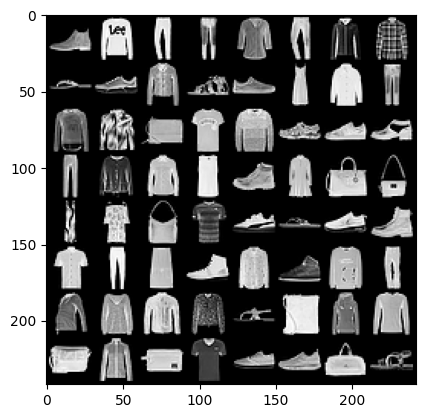

복원된 이미지입니다.


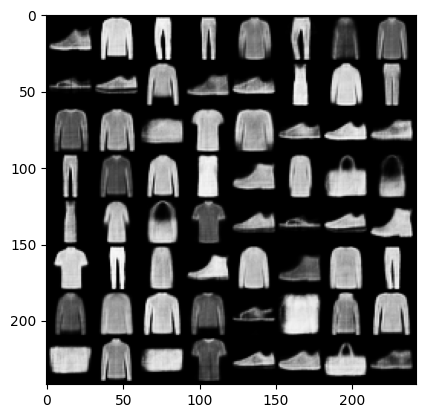

In [15]:
print("데이터 배치의 이미지입니다.")
plt.imshow(utils.make_grid(test_image[:64].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()

print("복원된 이미지입니다.")
plt.imshow(utils.make_grid(reconstruction[:64].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()

In [16]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(device)
    generated_images = vae.decode(noise)

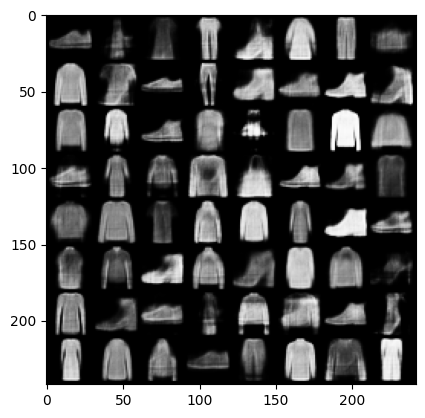

In [17]:
plt.imshow(utils.make_grid(generated_images[:64].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()

이 과정은 이론적으로 합리적이나, 한 가지 문제점이 있습니다. 샘플링 과정이 포함되는 경우 미분이 가능하지 않고, 이는 인공 신경망의 핵심적인 학습 방식인 기울기 하강 기반의 학습을 불가능하게 만듭니다. 이유는 간단합니다. 매 샘플링 시점마다 기울기를 계산해야 할 평균과 분산이 변하기 때문입니다. 이를 해결하기서는 평균과 분산을 고정해야 하는데, 그것은 다시 오토 인코더와 같아지게 되므로, 우리는 이를 다른 방식으로 해결합니다. 샘플링 과정이 포함된 계산이 기울기를 계산할 수 없다는 것을 해결하기 위한 제안된 방식이 **재매개변수화**입니다. 재매개변수화는 정규 분포의 특성에 기인하여 동작합니다. 정규 분포에서 평균 $\mu$ 과 표준편차 $\sigma$을 고정한 채로 임의의 노이즈 $\epsilon$을 정규 분포에서 샘플링한 후 $\mu + \sigma^2 * \epsilon$을 계산하면, 이 값은 $(\mu, \sigma^2)$에서 샘플링한 임의의 값과 같다는 것입니다. 수식으로 표현하면 아래와 같습니다.
$$z \sim N(\mu, \sigma^2I) \leftrightarrow z = \mu + \sigma^2 * \epsilon, \epsilon \sim N(0, I)$$

💡 정규 분포에서 평균이 10, 표준편차가 5인 값을 1000개 샘플링합니다.

In [18]:
import numpy as np

mean = 10; std = 5; N = 1000

In [19]:
dist_origin = np.random.normal(mean, std, N)
print(f"정규 분포에서 샘플링한 데이터의 평균은 {dist_origin.mean()} 입니다.")
print(f"정규 분포에서 샘플링한 데이터의 표준 편차는 {dist_origin.std()} 입니다.")

정규 분포에서 샘플링한 데이터의 평균은 9.895675546021828 입니다.
정규 분포에서 샘플링한 데이터의 표준 편차는 5.055973865630012 입니다.


정규 분포에서 평균이 0, 표준편차가 1인 값을 1000개 샘플링한 후, 재매개변수화를 통해 평균이 10, 표준편차가 5인 정규 분포처럼 만들어줍니다.

In [20]:
dist_reparam = mean + std*np.random.normal(0, 1, N)
print(f"재매개변수화를 적용한 데이터의 평균은 {dist_reparam.mean()} 입니다.")
print(f"재매개변수화를 적용한 데이터의 표준 편차는 {dist_reparam.std()} 입니다.")

재매개변수화를 적용한 데이터의 평균은 10.032806804115465 입니다.
재매개변수화를 적용한 데이터의 표준 편차는 5.0404795469619765 입니다.


분포 그래프를 통해 시각적으로 확인해봅니다.

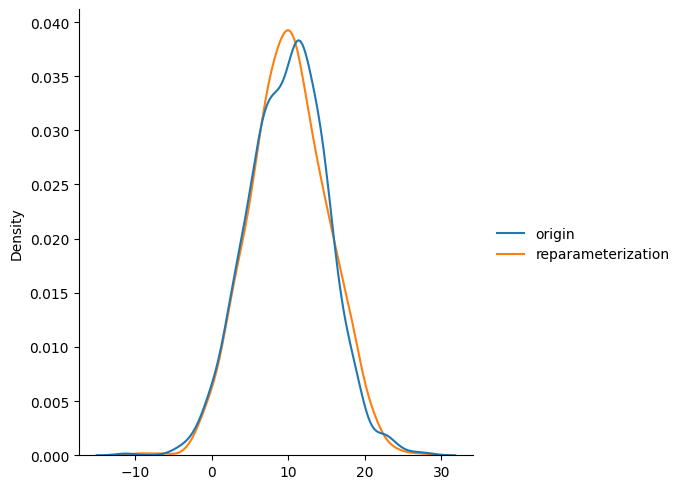

In [21]:
import seaborn as sns

sns.displot(
    dict(
        origin=dist_origin,
        reparameterization=dist_reparam
    ), multiple="layer", kind="kde"
)

손실 함수 관점에서, 변분 오토 인코더와 오토 인코더의 유일한 차이는 KL-Divergence 하나 뿐입니다. 즉 오토 인코더와 구분되는 변분 오토 인코더의 핵심 중 하나입니다. 실습에서는 왜 변분 오토 인코더가 KL-Divergnce를 이용하여 ELBO를 계산하게 되는지까지는 다루지 않습니다. KL-Divergence는 두 확률 분포 $P, Q$가 있을 때, 두 분포의 **발산 (거리 X!!)**입니다. 수식으로는 아래와 같이 표현됩니다.
$$D_{KL}(P||Q) = \sum_{i}{P(i)\log\frac{P(i)}{Q(i)}}$$

KL-Divergence는 임의의 확률 분포 $P$가 있을 때, 그 분포와 발산이 적은 (근사하는) 확률 분포 $Q$를 찾고 싶을 때 활용될 수 있습니다. 즉, $P$를 얻을 수 없는 경우, 우리가 쉽게 계산할 수 있는 분포인 $Q$를 이용하여 근사하는 것입니다.

변분 오토 인코더는 $Q$를 정규 분포로 가정하고, 원본 데이터 $X$의 분포로의 근사를 KL-Divergence를 이용하여 수행합니다.

KL-Divergence를 정의합니다. VAE에서는 평균이 0, 표준편차가 1인 정규 분포와의 발산을 평가할 것이므로 수식을 변형하여 구현합니다.

In [22]:
def KLDivergenceLoss(mean, log_var):
    return torch.sum(-0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()))

여러가지 정규 분포를 생성하여 표준 정규 분포와 발산을 계산하고 비교합니다.

1. 평균이 1이고 표준편차가 2인 정규 분포

In [23]:
dist_origin = np.random.normal(0, 1, 1000)

KL-Divergence 값은 1.3068528175354004 입니다.


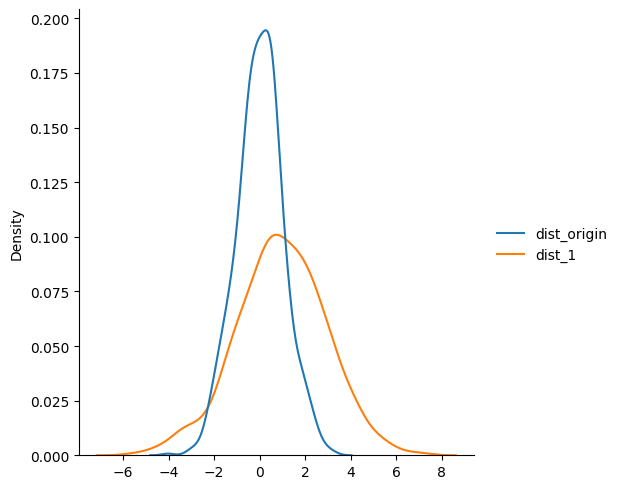

In [24]:
mu, sigma = 1, 2
dist_1 = np.random.normal(mu, sigma, 1000)

sns.displot(
    dict(
        dist_origin=dist_origin,
        dist_1=dist_1,
    ), multiple="layer", kind="kde"
)

kld = KLDivergenceLoss(torch.Tensor([mu]), torch.Tensor([np.log(np.square(sigma))]))
print(f"KL-Divergence 값은 {kld} 입니다.")

2. 평균이 2이고 표준편차가 0.1인 정규 분포

KL-Divergence 값은 3.8075852394104004 입니다.


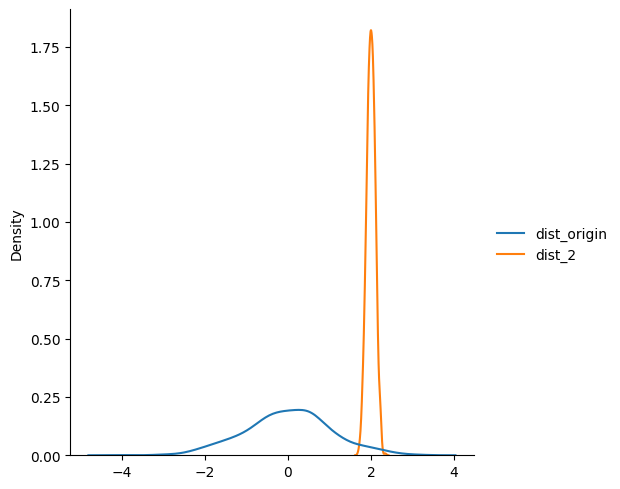

In [25]:
mu, sigma = 2, 0.1
dist_2 = np.random.normal(mu, sigma, 1000)

sns.displot(
    dict(
        dist_origin=dist_origin,
        dist_2=dist_2,
    ), multiple="layer", kind="kde"
)

kld = KLDivergenceLoss(torch.Tensor([mu]), torch.Tensor([np.log(np.square(sigma))]))
print(f"KL-Divergence 값은 {kld} 입니다.")

3. 평균이 0이고 표준편차가 1인 표준 정규 분포

KL-Divergence 값은 0.0 입니다.


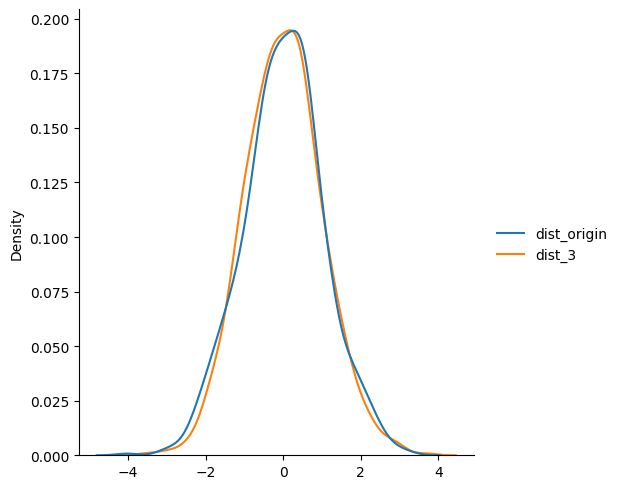

In [26]:
mu, sigma = 0, 1
dist_3 = np.random.normal(mu, sigma, 1000)

sns.displot(
    dict(
        dist_origin=dist_origin,
        dist_3=dist_3,
    ), multiple="layer", kind="kde"
)

kld = KLDivergenceLoss(torch.Tensor([mu]), torch.Tensor([np.log(np.square(sigma))]))
print(f"KL-Divergence 값은 {kld} 입니다.")